In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV 
import seaborn as sns

### Reading Data

In [2]:
train = pd.read_csv('./train_data_resamples.csv')
test = pd.read_csv('./test_data_resamples.csv')

In [3]:
print("Training Data Size: ", train.shape)
print("Testing Data Size: ", test.shape)

Training Data Size:  (98, 54)
Testing Data Size:  (47, 54)


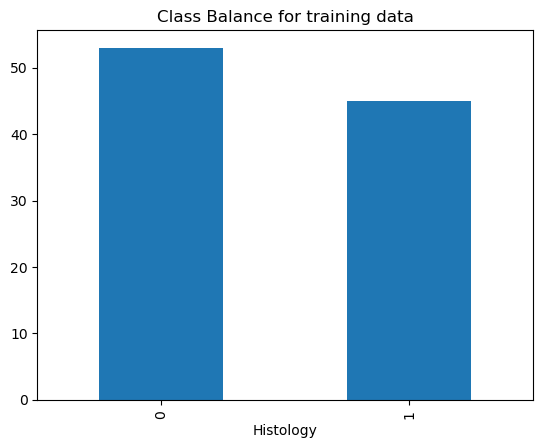

In [4]:
#checking class balance plot grouby label
train.groupby('Histology').size().plot(kind='bar')
plt.title('Class Balance for training data')
plt.show()

### Feature Selection

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Columns that should not be scaled
columns_to_exclude = ['Case ID', 'Histology']

# Columns that should be scaled
columns_to_scale = train.columns.difference(columns_to_exclude)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to your data and transform the data
df_scaled = scaler.fit_transform(train[columns_to_scale])

# Create a new DataFrame with the scaled values in the relevant columns
df_scaled = pd.DataFrame(df_scaled, columns=columns_to_scale, index=train.index)

# Concatenate the non-scaled and scaled columns to form the full DataFrame
data = pd.concat([train[columns_to_exclude], df_scaled], axis=1)

# Initialize a classifier
clf = RandomForestClassifier(n_estimators=100)

X = train.drop(['Case ID', 'Histology'], axis=1)
Y = train['Histology']
# Use RFECV for feature selection
selector = RFECV(estimator=clf, step=1, cv=5)
selector = selector.fit(X, Y)

# Select the important features based on RFE
X_train_selected = selector.transform(X)


print(f"Number of features selected: {selector.n_features_}")
print(f"Selected features: {X.columns[selector.support_]}")
selected_columns = X.columns[selector.support_]

Number of features selected: 9
Selected features: Index(['Age at Histological Diagnosis', 'Weight (lbs)', '%GG',
       'EGFR mutation status', 'KRAS mutation status',
       'ALK translocation status', 'HPGD', 'CD44', 'VIM'],
      dtype='object')


In [6]:
X_train = train[selected_columns]
X_test = test[selected_columns]
y_train = train['Histology'] 
y_test = test['Histology']

### Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = { "C":np.logspace(-4, 4, 50), 
         "penalty":["l1"], 
         'solver': ['liblinear']}
logreg = LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.8286427728546842, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.7844444444444445


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = { "C":np.logspace(-4, 4, 50), 
         "penalty":["l2"]}
logreg = LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.08685113737513521, 'penalty': 'l2'}
accuracy : 0.7644444444444445


              precision    recall  f1-score   support

           0       0.73      0.92      0.81        26
           1       0.86      0.57      0.69        21

    accuracy                           0.77        47
   macro avg       0.79      0.75      0.75        47
weighted avg       0.79      0.77      0.76        47



<Axes: >

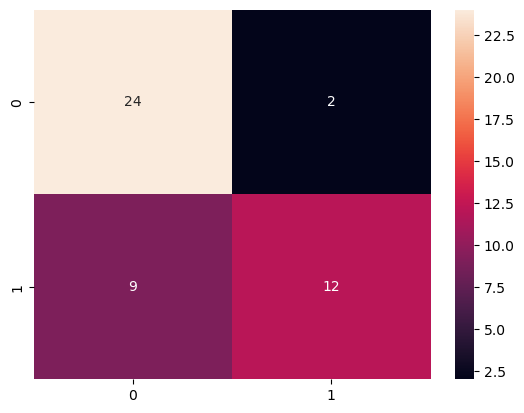

In [13]:
logreg = LogisticRegression(max_iter=1000, C=0.8286427728546842, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')